In [5]:
from sklearn.datasets import fetch_olivetti_faces

In [6]:
olivetti_faces = fetch_olivetti_faces(data_home='./face_data', shuffle=True)
print(olivetti_faces.data.shape)
print(olivetti_faces.target.shape)
print(olivetti_faces.images.shape)

(400, 4096)
(400,)
(400, 64, 64)


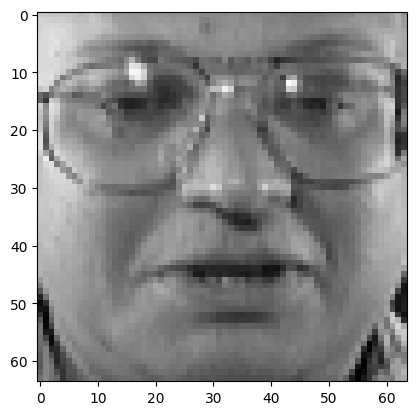

In [7]:
import matplotlib.pyplot as plt

face = olivetti_faces.images[1]
plt.imshow(face, cmap='gray')
plt.show()

In [8]:
olivetti_faces.data[1]

array([0.76859504, 0.75619835, 0.74380165, ..., 0.48347107, 0.6280992 ,
       0.6528926 ], dtype=float32)

In [9]:
olivetti_faces.data[1].shape

(4096,)

In [10]:
olivetti_faces.target

array([13, 30, 34, 19, 24,  6, 15, 26, 14, 21,  3, 13, 11, 34,  1,  5, 29,
       14, 20, 19, 17, 26, 12, 34, 17, 31,  7,  1, 28, 10, 17, 30, 33, 22,
        6,  7,  9, 17, 17, 39, 10, 32,  0,  0, 29,  5, 37, 25, 15, 23, 24,
       14, 29, 17, 28, 31,  5,  1,  2,  4,  7, 27,  0, 35, 19, 37, 14,  0,
       15, 31,  0, 26,  6,  2, 10,  1, 36, 30, 36, 32, 33,  6,  5, 10, 30,
       22, 12, 37, 39, 32, 38, 25,  5,  0, 19, 14, 13, 39, 26, 36, 25,  6,
       31, 15, 28, 34,  8, 34, 15, 29,  9,  8, 29,  2, 36, 21, 25,  4, 23,
       34,  9, 22, 23, 23, 37, 14,  2, 25, 35, 16, 15, 39,  6, 24, 21, 10,
       31, 19, 32,  1, 16, 18,  3, 11, 26, 10, 35, 24, 23, 11, 33, 12, 28,
       11, 21, 13, 27, 12, 19, 29, 28, 13,  3, 37, 16,  3, 23,  9,  8,  6,
       16, 28, 20, 39, 23, 28, 10,  4, 32, 39, 22,  7, 13, 38, 22, 21,  2,
       18, 36, 27,  5, 32, 35,  2,  0, 21, 15, 21, 37, 22, 13, 23, 21, 27,
       27, 30, 23,  3, 20, 39,  6,  2, 33,  4, 24, 12,  9, 11, 16, 38, 38,
       34,  4,  1, 28,  7

In [11]:
olivetti_faces.target.shape

(400,)

In [12]:
import torch
import torch.nn as nn

In [13]:
images = torch.tensor(olivetti_faces.data)
targets = torch.tensor(olivetti_faces.target)

In [14]:
images.shape

torch.Size([400, 4096])

In [15]:
targets.shape

torch.Size([400])

In [16]:
dataset = [(img,lbl) for img,lbl in zip(images, targets)]
dataset[0]

(tensor([0.6694, 0.6364, 0.6488,  ..., 0.0868, 0.0826, 0.0744]),
 tensor(13, dtype=torch.int32))

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [18]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [23]:
# from torch_nn import TorchNN

# model = TorchNN()
# print(model)

model = nn.Sequential(
    nn.Linear(4096, 8192),
    nn.ReLU(),
    nn.Linear(8192, 16384),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(16384, 1024),
    nn.ReLU(),
    nn.Linear(1024, 40)
).to(device)  # 模型结构搬到GPU内存中

In [24]:
# 定义超参数
LR = 1e-3
epochs = 10
BATCH_SIZE = 128

In [ ]:
# 损失函数&优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
# 优化器（模型参数更新）
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [30]:
loss_hist = []
for epoch in range(epochs):
    # 提取训练数据
    for img, lbl in dataloader:
        # 前向运算
        output = model(img)
        # 计算损失
        lbl = lbl.long()
        loss = loss_fn(output, lbl)
        # 反向传播
        loss.backward()     # 计算梯度（参数.grad）
        optimizer.step()    # 更新参数
        optimizer.zero_grad()  # 梯度清零
        loss_hist.append(loss.item())
        print(f'epoch:{epoch+1} loss:{loss.item():.4f}')
    

epoch:1 loss:3.7050
epoch:1 loss:43.4405
epoch:1 loss:15.3100
epoch:1 loss:3.7767
epoch:1 loss:3.8979
epoch:1 loss:3.6739
epoch:1 loss:3.7435
epoch:1 loss:4.4296
epoch:1 loss:3.6363
epoch:1 loss:3.6491
epoch:1 loss:3.8019
epoch:1 loss:3.8546
epoch:1 loss:3.7160
epoch:1 loss:3.7351
epoch:1 loss:3.6753
epoch:1 loss:3.6418
epoch:1 loss:3.7203
epoch:1 loss:3.6861
epoch:1 loss:3.7168
epoch:1 loss:3.8121
epoch:1 loss:3.7788
epoch:1 loss:3.6964
epoch:1 loss:3.6857
epoch:1 loss:3.8216
epoch:1 loss:3.7954
epoch:1 loss:3.6779
epoch:1 loss:3.7439
epoch:1 loss:3.7842
epoch:1 loss:3.6517
epoch:1 loss:3.7788
epoch:1 loss:3.7329
epoch:1 loss:3.7742
epoch:1 loss:3.7275
epoch:1 loss:3.7027
epoch:1 loss:3.7125
epoch:1 loss:3.7288
epoch:1 loss:3.7105
epoch:1 loss:3.6782
epoch:1 loss:3.6835
epoch:1 loss:3.6484
epoch:2 loss:3.7458
epoch:2 loss:3.6350
epoch:2 loss:3.6703
epoch:2 loss:3.6184
epoch:2 loss:3.9046
epoch:2 loss:3.8442
epoch:2 loss:3.6736
epoch:2 loss:3.7243
epoch:2 loss:3.7028
epoch:2 loss:3.724

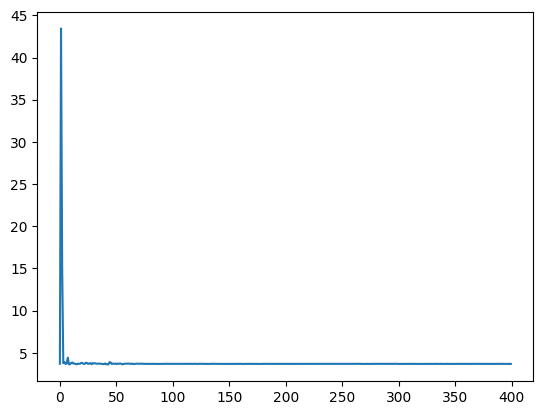

In [31]:
plt.plot(range(len(loss_hist)), loss_hist)
plt.show()